In [2]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import math
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmapF

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
PATCH_SIZE = 100

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/example_sodlt_iter_10000.caffemodel'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/sodlt_deploy.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/mean.npy'

In [4]:
mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 131.45718247  100.44726317  103.41435365]


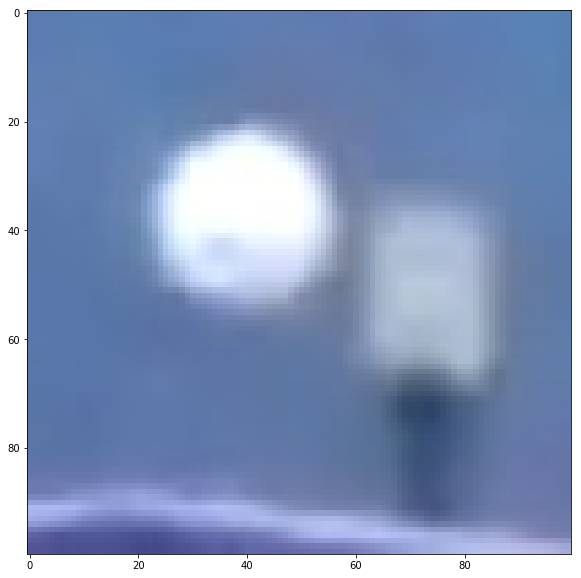

In [5]:
img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R027801.jpg'
prob_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R027801.prob.jpg'

#batch_size = net.blobs['data'].data.shape[0]

image = caffe.io.load_image(img_name)
plt.imshow(image)

0.000872471 0.898052


(-0.5, 49.5, 49.5, -0.5)

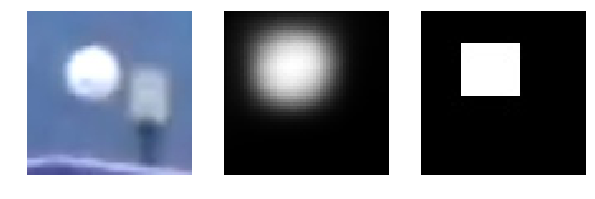

In [58]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

sodlt = output['sodlt'][0]
sodlt = 1/(1+np.exp(-sodlt[0]))
print np.min(sodlt), np.max(sodlt)

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

In [7]:
#speed
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 34.5 ms per loop


In [8]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 100, 100)
conv1	(1, 96, 23, 23)
pool1	(1, 96, 11, 11)
norm1	(1, 96, 11, 11)
conv2	(1, 256, 11, 11)
pool2	(1, 256, 5, 5)
norm2	(1, 256, 5, 5)
conv3	(1, 384, 5, 5)
conv4	(1, 384, 5, 5)
conv5	(1, 256, 5, 5)
pool5	(1, 256, 2, 2)
sodlt_fc6	(1, 4096)
sodlt_fc7	(1, 1024)
sodlt_fc8	(1, 2500)
sodlt	(1, 1, 50, 50)


In [9]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
sodlt_fc6	(4096, 1024) (4096,)
sodlt_fc7	(1024, 4096) (1024,)
sodlt_fc8	(2500, 1024) (2500,)


In [10]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

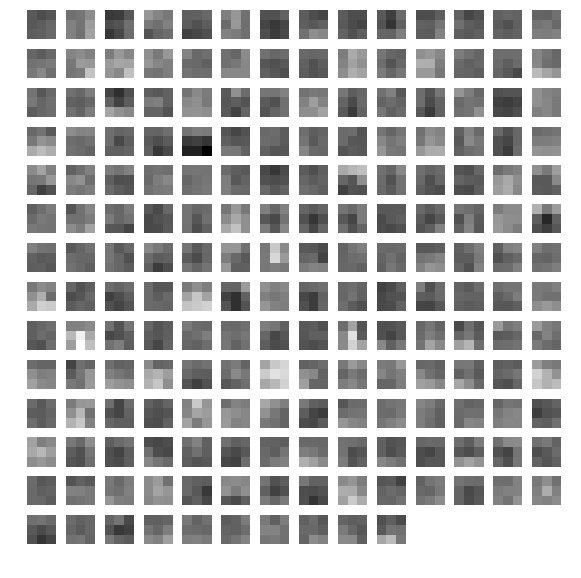

In [11]:
# the parameters are a list of [weights, biases]
#filters = net.params['conv1'][0].data
#vis_square(filters.transpose(0, 2, 3, 1))
filters = net.params['conv5'][0].data
vis_square(filters[1])
#print filters[4][3]

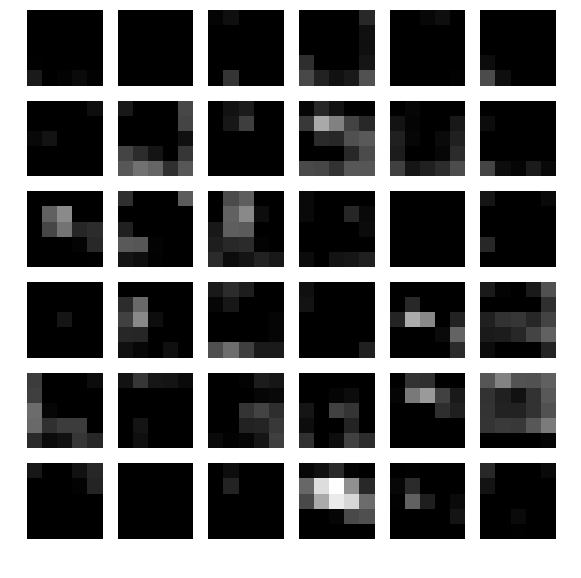

In [12]:
feat = net.blobs['conv4'].data[0, :36]
vis_square(feat)

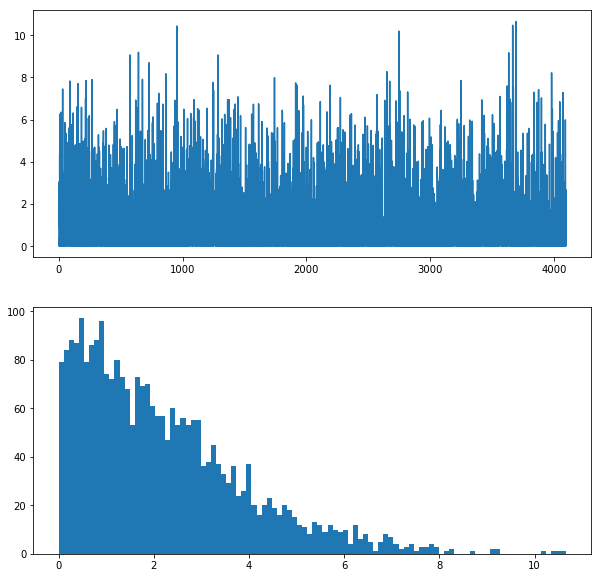

In [13]:
feat = net.blobs['sodlt_fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

(-0.5, 49.5, 49.5, -0.5)

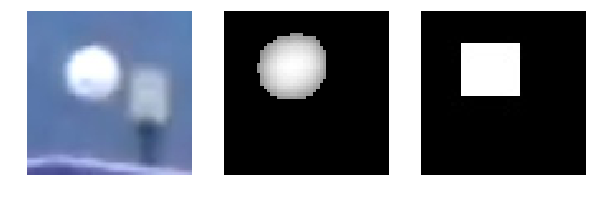

In [66]:
sodlt[sodlt<0.4] = 0

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

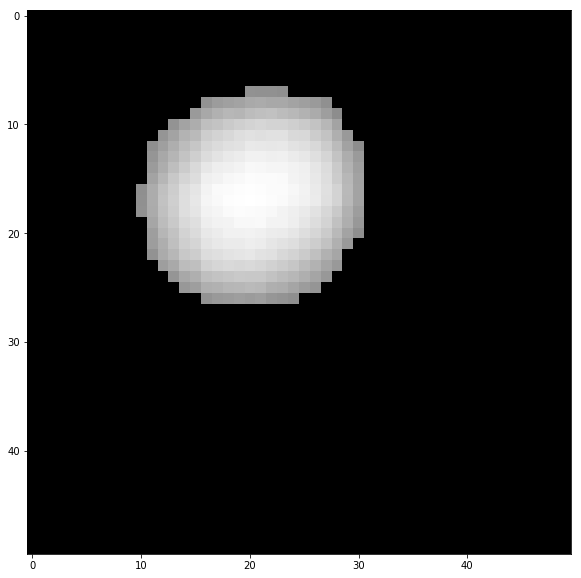

In [67]:
import cv2

sodlt_int = (sodlt*255).astype(np.uint8)
output_img = image.copy()
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(sodlt_int)

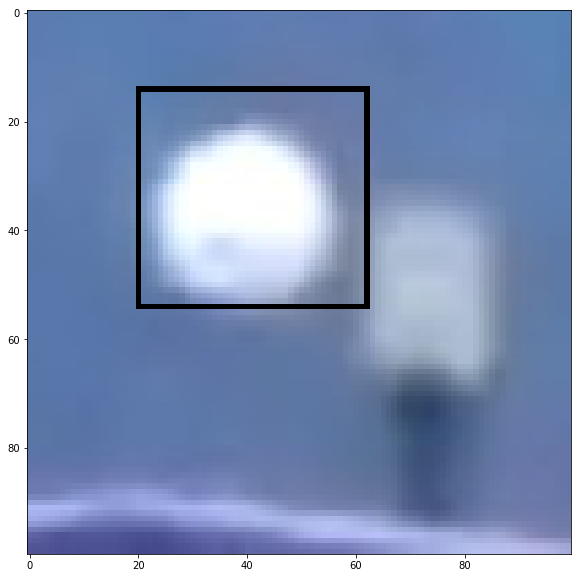

In [68]:
npaContours, npaHierarchy = cv2.findContours(sodlt_int.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for npaContour in npaContours:
    if cv2.contourArea(npaContour) > 10:
        [x,y,w,h] = cv2.boundingRect(npaContour)
        cv2.rectangle(output_img, (x*2,y*2), ((x+w)*2, (y+h)*2), (0,0,255), 1)

plt.imshow(output_img)